In [1]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:

dataset = spark.read.csv('/content/customer_segmentation_dataset.csv',inferSchema=True, header =True)\
.toDF("age", "annual_income", "spending_score", "years_as_customer", "number_of_purchases","customer_segment")


dataset.select('customer_segment').distinct().show(10)
dataset.count()

+----------------+
|customer_segment|
+----------------+
|    Medium Value|
|      High Value|
|       Low Value|
+----------------+



2000000

In [5]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(\
inputCols=["age", "annual_income", "spending_score", "years_as_customer", "number_of_purchases"],\
outputCol="features")
df_temp = vector_assembler.transform(dataset)
df_temp.show(3)

+---+-------------+--------------+-----------------+-------------------+----------------+--------------------+
|age|annual_income|spending_score|years_as_customer|number_of_purchases|customer_segment|            features|
+---+-------------+--------------+-----------------+-------------------+----------------+--------------------+
| 22|       113441|            19|                2|                 44|       Low Value|[22.0,113441.0,19...|
| 47|        85415|            74|                7|                 11|    Medium Value|[47.0,85415.0,74....|
| 60|        78075|            18|               19|                 37|       Low Value|[60.0,78075.0,18....|
+---+-------------+--------------+-----------------+-------------------+----------------+--------------------+
only showing top 3 rows



In [6]:
#Let’s remove unnecessary columns:
df = df_temp.drop('age', 'annual_income', 'spending_score', 'years_as_customer', 'number_of_purchases')
df.show(3)

+----------------+--------------------+
|customer_segment|            features|
+----------------+--------------------+
|       Low Value|[22.0,113441.0,19...|
|    Medium Value|[47.0,85415.0,74....|
|       Low Value|[60.0,78075.0,18....|
+----------------+--------------------+
only showing top 3 rows



In [7]:
from pyspark.ml.feature import StringIndexer
l_indexer = StringIndexer(inputCol="customer_segment", outputCol="customer_segmentIndex")
df = l_indexer.fit(df).transform(df)
df.select('customer_segment','customer_segmentIndex').distinct().show(3)

+----------------+---------------------+
|customer_segment|customer_segmentIndex|
+----------------+---------------------+
|      High Value|                  2.0|
|    Medium Value|                  1.0|
|       Low Value|                  0.0|
+----------------+---------------------+



In [8]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])

In [9]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dt = DecisionTreeClassifier(labelCol="customer_segmentIndex", featuresCol="features",impurity='entropy', maxDepth=4,seed=1234)
model = dt.fit(trainingData)
predictions = model.transform(testData)

In [10]:
evaluator = MulticlassClassificationEvaluator(\
labelCol="customer_segmentIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test accuracy =  " , accuracy)
print(model.toDebugString)

Test accuracy =   0.9799477681385645
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_92ea661dd2ec, depth=2, numNodes=5, numClasses=3, numFeatures=5
  If (feature 2 <= 49.5)
   Predict: 0.0
  Else (feature 2 > 49.5)
   If (feature 2 <= 74.5)
    Predict: 1.0
   Else (feature 2 > 74.5)
    Predict: 2.0



In [11]:
#Multiclassification using Logisitc Regression

# this is code for multiple classification using logistic Regression
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import LogisticRegression
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
lr = LogisticRegression(maxIter=100, \

                        featuresCol="features", \

                        labelCol='customer_segmentIndex')
ovr = OneVsRest(classifier=lr, \
                labelCol='customer_segmentIndex', \
                featuresCol='features')
#from pyspark.ml import Pipeline
#pipeline_ovr = Pipeline(stages=[vecAssembler, stdScaler, ovr])
#pipelineModel_ovr = pipeline_ovr.fit(trainDF)

ovrModel = ovr.fit(train)
predictionsovr = ovrModel.transform(test)


evaluator = MulticlassClassificationEvaluator(\
labelCol="customer_segmentIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictionsovr)
print("Test accuracy =  " , accuracy)

Test accuracy =   1.0


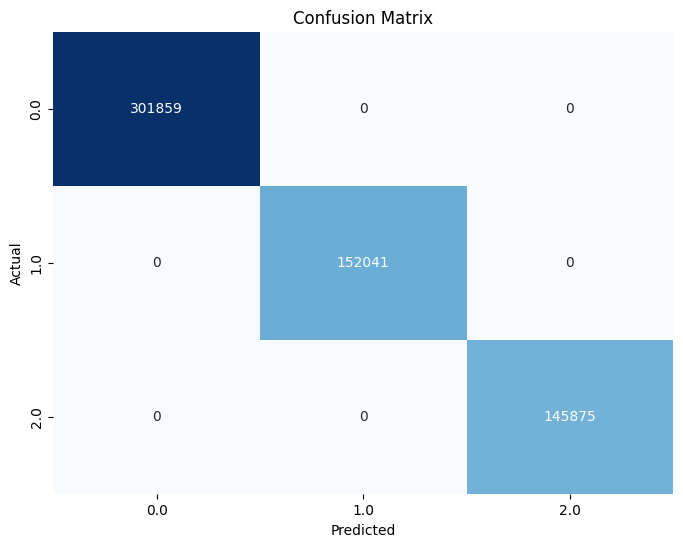

Test accuracy =   1.0


In [17]:
from pyspark.mllib.evaluation import MulticlassMetrics

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

# Create MulticlassMetrics object

 #Convert predictions and labels to RDD for MulticlassMetrics

prediction_and_labels = predictionsovr.select("prediction", "customer_segmentIndex") \
    .withColumnRenamed("Indexlabel", "customer_segment") \
    .toPandas()  # Convert to Pandas DataFrame for easier manipulation

# Create a confusion matrix using Pandas
confusion_matrix = pd.crosstab(prediction_and_labels['customer_segmentIndex'], prediction_and_labels['prediction'], rownames=['Actual'], colnames=['Predicted'])



# Plot the confusion matrix using Seaborn and Matplotlib

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



evaluator = MulticlassClassificationEvaluator(\
labelCol="customer_segmentIndex", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictionsovr)
print("Test accuracy =  " , accuracy)